In [1]:
import pandas as pd

In [2]:
# todo: include TOB and whole blocks
DATA_DIR_PATH = "../.data/measurements/"
LABEL = "f18999999t20371443_txs_r1"

## Paired t-test

In [3]:
path = DATA_DIR_PATH + LABEL + ".csv"
df = pd.read_csv(path).drop_duplicates()
df = df.groupby(['id', 'run_type']).mean().reset_index() # For any duplicated block_num, we take the mean of the values 
df_wide = df.pivot(index='id', columns='run_type', values='exe_time').dropna(axis=0).reset_index()
print(f"Found {len(df_wide)} pairs")

Found 22 pairs


In [4]:
import scipy.stats as stats
import numpy as np

def perform_t_test(sample, alpha=0.05):
    t_stat, p_value = stats.ttest_1samp(sample, 1)

    print(f"mean-ratio: {np.mean(sample):.2f}")
    print(f"T-statistic: {t_stat:.2f}")
    print(f"P-value: {p_value:.2f}")

    print("\nVerdict:")
    if p_value < alpha:
        print(f"Reject the null hypothesis H0 at significance level {alpha}.")
        if t_stat < 0:
            print("H1: The mean latency of the new method is significantly less than the old one.")
        else:
            print("H2: The mean latency of the new method is significantly greater than the old one.")
    else:
        print("Fail to reject the null hypothesis H0: There is no significant difference in latency.")

### AOT vs Native

In [5]:
diff_ratios = (df_wide['aot'] - df_wide['native']) / df_wide['native']
perform_t_test(diff_ratios)

mean-ratio: -0.06
T-statistic: -54.72
P-value: 0.00

Verdict:
Reject the null hypothesis H0 at significance level 0.05.
H1: The mean latency of the new method is significantly less than the old one.


### JIT vs Native

In [6]:
# perform_t_test(df_wide['jit'], df_wide['native'])

## Histograms

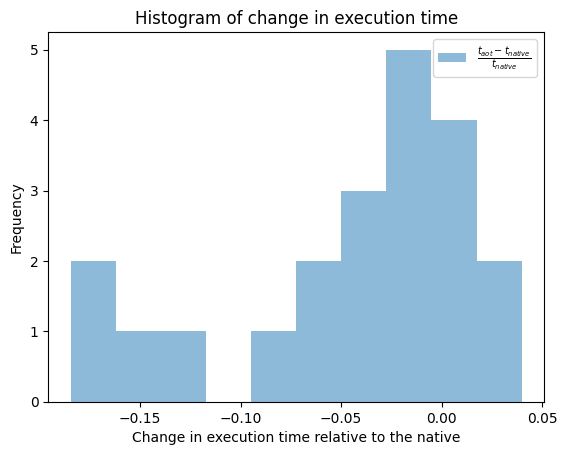

In [9]:
import matplotlib.pyplot as plt


# jit_diff = (df_wide['jit'] - df_wide['native']) \
#     .loc[lambda x: np.abs(stats.zscore(x)) < 2]
aot_diff = diff_ratios.loc[lambda x: np.abs(stats.zscore(x)) < 2] # Ignore 3-sigma outliers

# plt.hist(jit_diff, bins=100, alpha=0.5, label='jit-native')
plt.hist(aot_diff, bins=10, alpha=0.5, label=r"$\frac{t_{aot}-t_{native}}{t_{native}}$")

plt.xlabel('Change in execution time relative to the native')
plt.ylabel('Frequency')
plt.title('Histogram of change in execution time')
plt.legend()

plt.show()